In [1]:
# Global imports and settings
from preamble import *
%matplotlib inline
plt.rcParams['savefig.dpi'] = 100 # Use 300 for PDF, 100 for slides
#InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

## Feature Engineering
Joaquin Vanschoren, Eindhoven University of Technology

## Feature engineering

* In reality, data won't be as nicely represented as we've seen thus far
* Many of the algorithms that we've seen are greatly affected by _how_ data is represented
* Examples: Scaling, numeric/categorical values, missing values, feature selection/construction
* We typically need chain together different algorithms
    - Many _preprocessing_ steps
    - Possibly many models
* This is called a _pipeline_ (or _workflow_)
* The best way to represent data depends not only on the semantics of the data, but also on the kind of model you are using.

### Overview
* Feature generation
    - **Polynomial features**: turn linear regression into polynomial regression
    - **Binning**: split a feature into multiple dimensions
    - **Product features**: model interactions between features
    - **Non-linear transformations**: log, sin,...
* Feature selection
    - Univariate techniques (e.g. ANOVA)
    - Model-based feature selection
    - Forward/backward selection
* Scaling
* Missing value imputation
* Pipelines
* Practical advice
    

### Polynomials

* We can make linear models behave more flexibly by adding polynomials of the original continuous features (also called a _basis expansion_). 

* For a given feature x, we might want to consider $x^2$, $x^3$, $x^4$, and so on.
    * This happens implictly in _kernelization_ (SVMs, GLMs, Gaussian Processes,...)
    
* We can do it explictly in scikit-learn, through `PolynomialFeatures` in the preprocessing module
    * `degree` is the max. degree of the polynomials, requires some searching
    * `include_bias` adds the 0-th polynomial, i.e. $x^0$

```python
poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly.fit(X).transform(X)
```

Linear regression can't capture the 'wave' in this data

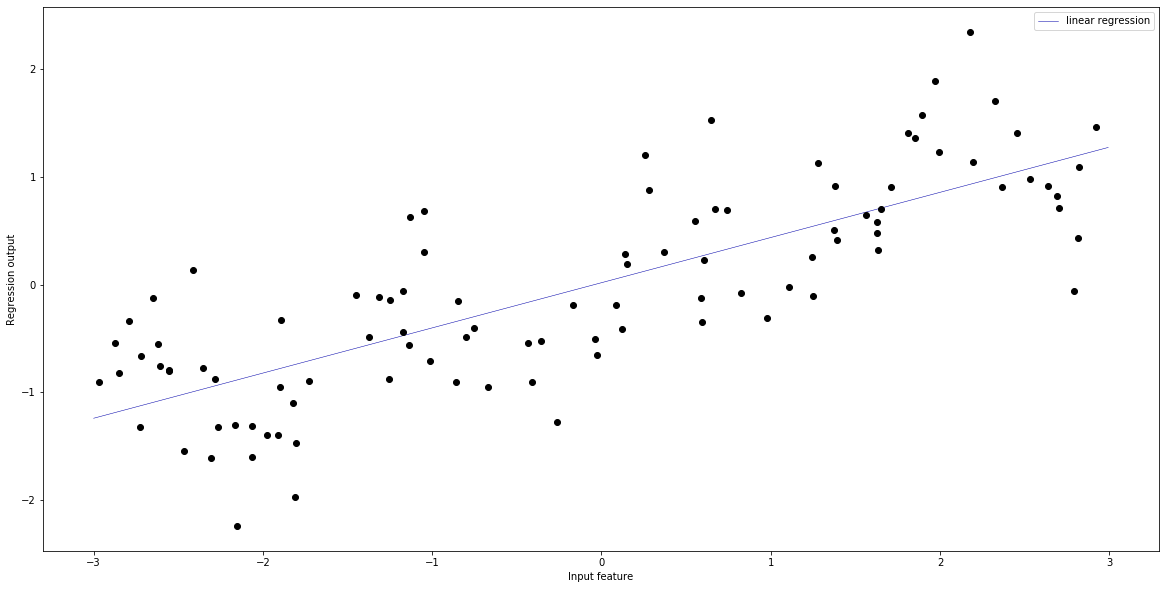

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = LinearRegression().fit(X, y)
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(line, reg.predict(line), label="linear regression")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

In [3]:
from sklearn.preprocessing import PolynomialFeatures

# include polynomials up to x ** 10:
# the default "include_bias=True" adds a features that's constantly 1
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)

Using a degree of 10 yields 10 features, with the original value raised to the n-th power.

In [4]:
styles = [dict(selector="td", props=[("font-size", "150%")]),dict(selector="th", props=[("font-size", "150%")])]
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head().style.set_table_styles(styles)

,x0,x0^2,x0^3,x0^4,x0^5,x0^6,x0^7,x0^8,x0^9,x0^10
0,-0.75,0.57,-0.43,0.32,-0.24,0.18,-0.14,0.1,-0.078,0.058
1,2.7,7.3,20,53,1.4e+02,3.9e+02,1.1e+03,2.9e+03,7.7e+03,2.1e+04
2,1.4,1.9,2.7,3.8,5.2,7.3,10,14,20,27
3,0.59,0.35,0.21,0.12,0.073,0.043,0.025,0.015,0.0089,0.0053
4,-2.1,4.3,-8.8,18,-37,77,-1.6e+02,3.3e+02,-6.8e+02,1.4e+03


Modelling polynomial features with linear regression yields _polynomial regression_.
* The model is still a hyperplane (in a 10-dimensional space)
* The predictions are now a non-linear function of the original variable X
* Fits the wave shape a lot better

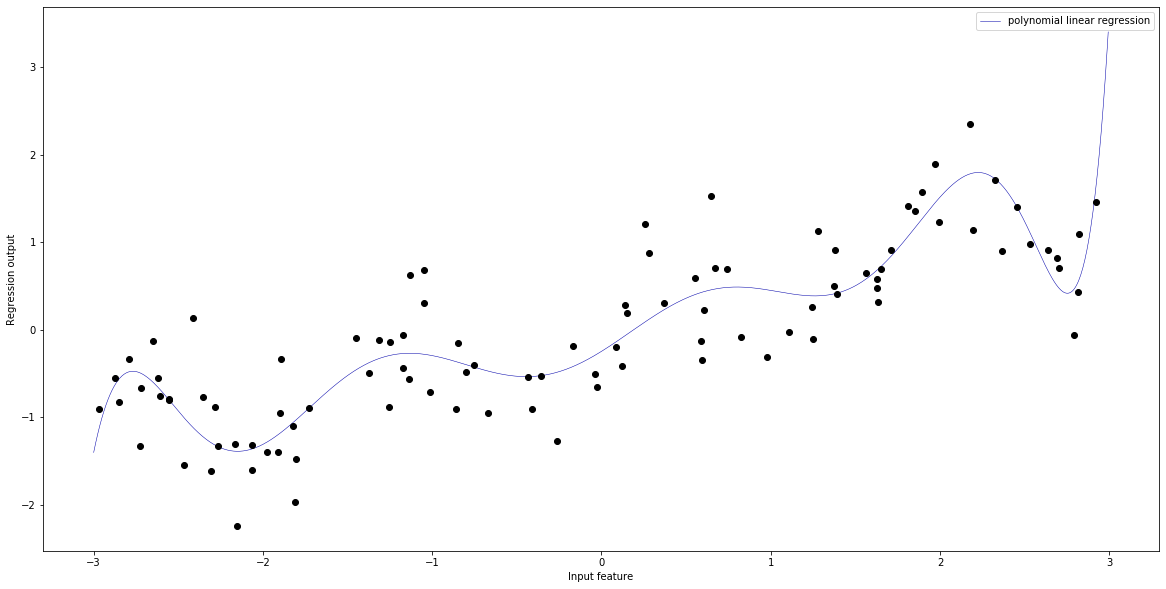

In [5]:
reg = LinearRegression().fit(X_poly, y)

line_poly = poly.transform(line)
plt.plot(line, reg.predict(line_poly), label='polynomial linear regression')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

### Binning (Discretization)

Sometimes we need a different model for different _ranges_ of the input data
- Partition (numeric) feature values into $n$ intervals (bins)
- Replace each feature with $n$ features
    - Value is 1 if the original feature value falls in the corresponding bin
    - Value is 0 otherwise
- Train the model on those $n$ features

- No handy sklearn function. You need to use:
    - `numpy.digitize` to assign values to bins
    - `OneHotEncoder` to convert a feature of $n$ numbers to $n$ binary features
    - `numpy.stack` to add the original feature
    
``` python
which_bin = numpy.digitize(X, bins=np.linspace(-3, 3, 11))
X_binned = OneHotEncoder(sparse=False).fit_transform(which_bin)
X_combined = np.hstack([X, X_binned])
```

In [6]:
from sklearn.preprocessing import OneHotEncoder

# create 11 equal bins
bins = np.linspace(-3, 3, 11)
# assign to bins
which_bin = np.digitize(X, bins=bins)
# transform using the OneHotEncoder.
encoder = OneHotEncoder(sparse=False)
# encoder.fit finds the unique values that appear in which_bin
encoder.fit(which_bin)
# transform creates the one-hot encoding
X_binned = encoder.transform(which_bin)
# Plot transformed data
bin_names = [('[%.1f,%.1f]') % i for i in zip(bins, bins[1:])]
df_orig = pd.DataFrame(X, columns=["orig"])
df_nr = pd.DataFrame(which_bin, columns=["which_bin"])
# add the original features
X_combined = np.hstack([X, X_binned])
pd.DataFrame(X_combined, columns=["orig"]+bin_names).head().style.set_table_styles(styles)

,orig,"[-3.0,-2.4]","[-2.4,-1.8]","[-1.8,-1.2]","[-1.2,-0.6]","[-0.6,0.0]","[0.0,0.6]","[0.6,1.2]","[1.2,1.8]","[1.8,2.4]","[2.4,3.0]"
0,-0.75,0,0,0,1,0,0,0,0,0,0
1,2.7,0,0,0,0,0,0,0,0,0,1
2,1.4,0,0,0,0,0,0,0,1,0,0
3,0.59,0,0,0,0,0,1,0,0,0,0
4,-2.1,0,1,0,0,0,0,0,0,0,0


* Our linear model learned a fixed slope for each bin in the wave dataset
    * Because we learn a single weight for feature _x_

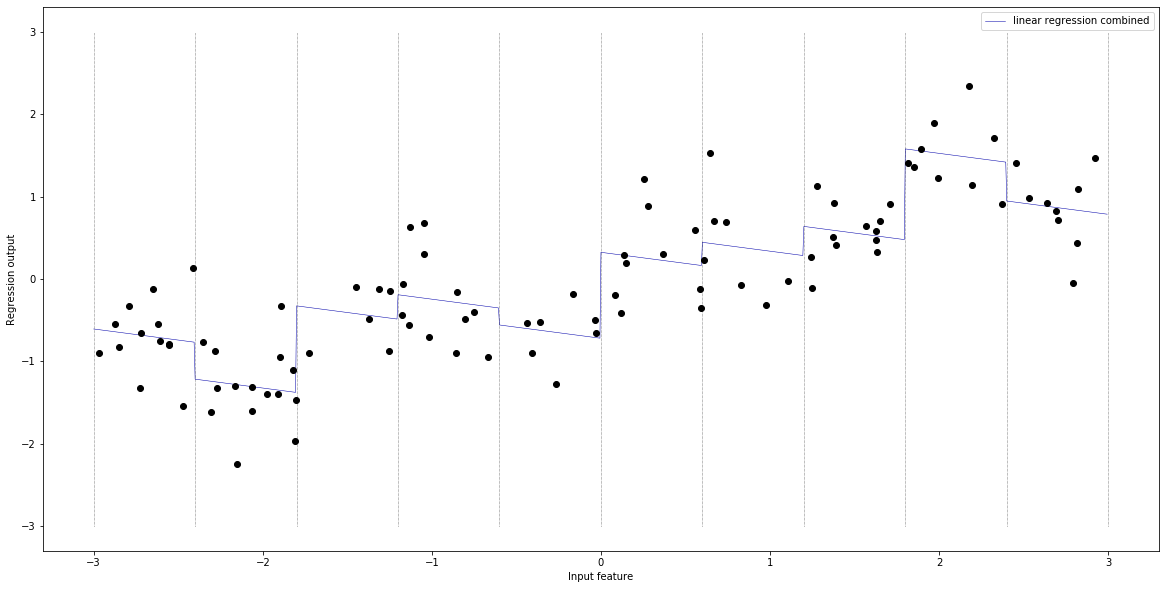

In [7]:
line_binned = encoder.transform(np.digitize(line, bins=bins))
reg = LinearRegression().fit(X_combined, y)

line_combined = np.hstack([line, line_binned])
plt.plot(line, reg.predict(line_combined), label='linear regression combined')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.plot(X[:, 0], y, 'o', c='k');

### Interaction features

* If we want a different slope per bin, we need _interaction features_ (or _product features_)
* These are the product of the bin encoding and the original feature value

In [8]:
X_product = np.hstack([X_binned, X * X_binned])
bin_sname = ["b" + str(s) for s in range(10)] 
pd.DataFrame(X_product, columns=bin_sname+["X*" + s for s in bin_sname]).head().style.set_table_styles(styles)

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,X*b0,X*b1,X*b2,X*b3,X*b4,X*b5,X*b6,X*b7,X*b8,X*b9
0,0,0,0,1,0,0,0,0,0,0,-0,-0,-0,-0.75,-0,-0,-0,-0,-0,-0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2.7
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.4,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.59,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,-0,-2.1,-0,-0,-0,-0,-0,-0,-0,-0


The interaction features allow the linear model to learn a weight (slope) per bin

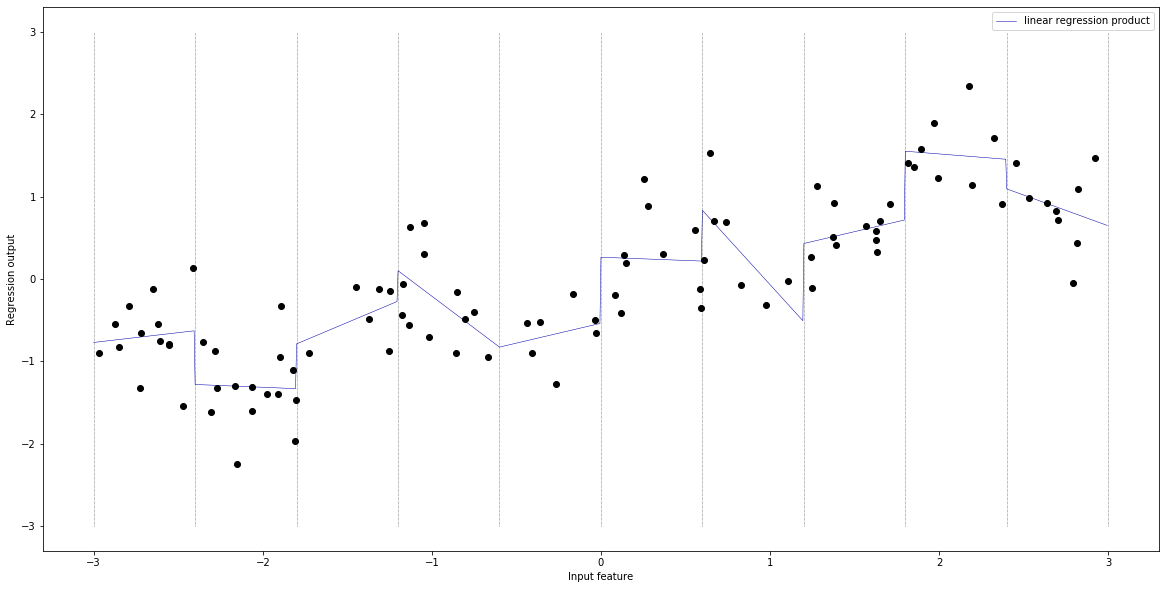

In [9]:
reg = LinearRegression().fit(X_product, y)

line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, reg.predict(line_product), label='linear regression product')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

### Non-linear transformations

There are other transformations that often prove useful for transforming certain features.

For instance, `log` or `exp` are very useful to better scale your data. This is useful for models that are sensitive to feature scales, such as linear models, SVMs and neural networks.

The functions log and exp can help by adjusting the relative scales, tranforming them to more Gaussian-like value distributions.

Finding the transformation that works best for each combination of dataset and model is somewhat of an art.

##### Example: Poisson distributions 
    
Imagine a process where many outcomes are rare (only occur 1 or 2 times) while other occur hundreds of times

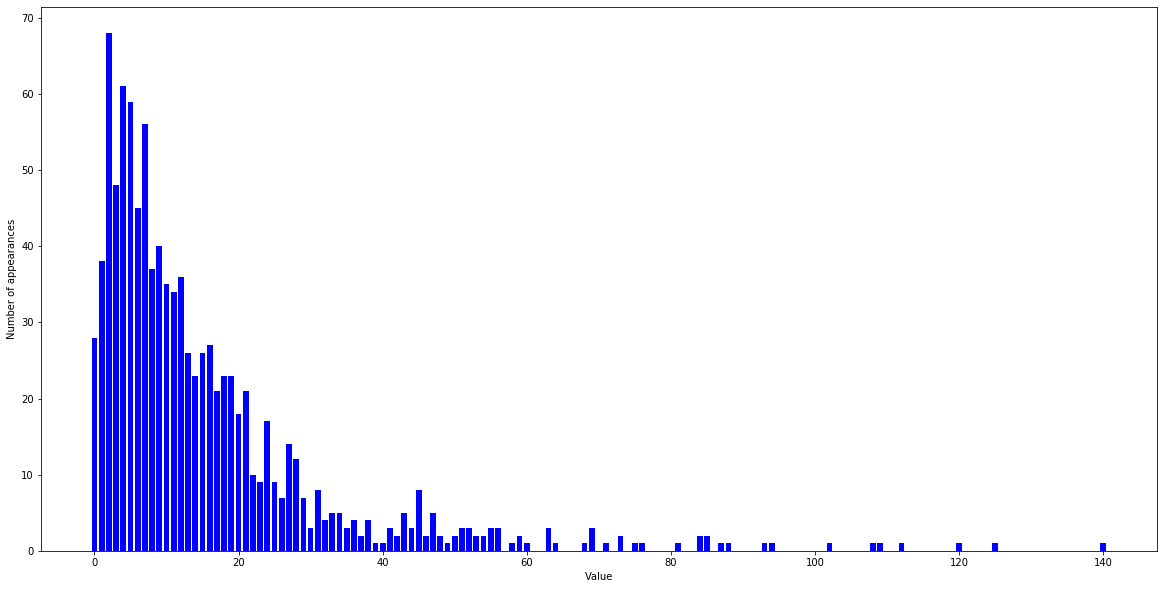

In [10]:
rnd = np.random.RandomState(0)
X_org = rnd.normal(size=(1000, 3))
w = rnd.normal(size=3)

X = rnd.poisson(10 * np.exp(X_org))
y = np.dot(X_org, w)

bins = np.bincount(X[:, 0])
plt.bar(range(len(bins)), bins, color='b')
plt.ylabel("Number of appearances")
plt.xlabel("Value");

Applying a logarithmic transformation can help to create a more normal distribution
```
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)
```

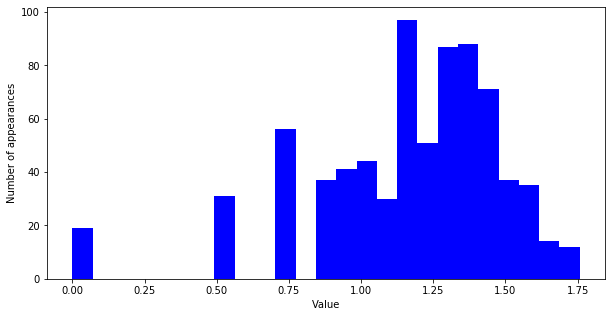

In [11]:
# We actually compute log(x+1) to avoid the occurrence of log(0)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)

plt.rcParams['figure.figsize'] = [10, 5]
plt.hist(np.log(X_train_log[:, 0] + 1), bins=25, color='b')
plt.ylabel("Number of appearances")
plt.xlabel("Value");

### Poisson Regression

Most linear models can’t handle non-normal distributions well:
``` python
score = Ridge().fit(X_train, y_train).score(X_test, y_test)
```

In [12]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

score = Ridge().fit(X_train, y_train).score(X_test, y_test)
print("Ridge regression (original data) test score (R2): {:.3f}".format(score))

Ridge regression (original data) test score (R2): 0.622


But do a lot better if the data is transformed:
``` python
score = Ridge().fit(X_train_log, y_train).score(X_test_log, y_test)
```

In [13]:
score = Ridge().fit(X_train_log, y_train).score(X_test_log, y_test)
print("Ridge regression (transformed data) test score (R2): {:.3f}".format(score))

Ridge regression (transformed data) test score (R2): 0.875


## Automatic Feature Selection

It can be a good idea to reduce the number of features to only the most useful ones
- Simpler models that generalize better (less overfitting)
    - Even models such as RandomForest can benefit from this
- Help algorithms that are sensitive to the curse of dimensionality
    - e.g. kNN and many other distance-based methods
- Sometimes it is one of the main methods to improve models (e.g. gene expression data)

##### Example: Iris
Below are the distributions (histograms) of every class according to every feature.  
Which of the four features is most informative?

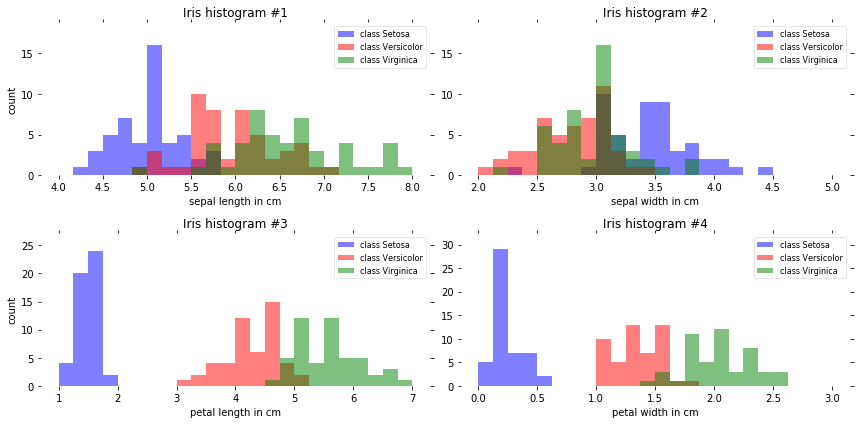

In [14]:
import math
from sklearn.datasets import load_iris

iris_dataset = load_iris()

X = iris_dataset['data']
y = iris_dataset['target']+1
label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):  

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       

plt.show()

### Univariate statistics

* Keep features for which there is a __statistically significant relationship__ between it and the target.
* Consider each feature individually (univariate), independent of the model that you might want to apply afterwards.
* We can use different tests to measure how informative a feature is: 

`f_regression`: For numeric targets. Measures the performance of a linear regression model trained on only one feature.

`f_classif`: For categorical targets. Measures the _F-statistic_ from one-way Analysis of Variance (ANOVA), or the proportion of total within-class variance explained by one feature.

`chi2`: For categorical features and targets. Performs the chi-square ($\chi^2$) statistic. Similar results as F-statistic, but less sensitive to nonlinear relationships.

* Both the F-statistic and $\chi^2$ methods use the p-value under the F- and $\chi^2$ distribution, respectively.
* F-statistic = $\frac{var(\mu_i)}{\overline{var}(X_i)}$ (higher is better)  
    * $X_i$: all samples with class i.  
    * Better if per-class distributions separate well: means are far apart and variance is small.

<img src="../images/03_fstatistic.png" alt="ml" style="width: 500px;"/>

Chi-squared for a feature with $c$ categories and $k$ classes:

$$\chi^2 = \sum_{i=0}^{c} \sum_{j=0}^{k} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$

where $O_{ij}$ is the number of observations of feature category $i$ and class $j$, and $E_{ij}$ is the expected number of observations of category $i$ and class $j$ if there was no relationship between the feature and the target (number of samples of category $i$ * ratio of class $j$).


In [15]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# add noise features to the data
# the first 30 features are from the dataset, the next 50 are noise
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=.5)

#### In practice

* Given a feature ranking, sklearn has two general ways to remove features :
- `SelectKBest` will only keep the $k$ features with the lowest p values. 
- `SelectPercentile` selects a fixed percentage of features. 
* Retrieve the selected features with `get_support()`

Visualization: 
* Classification dataset with 30 real features, and add 50 random noise features.  
    * Ideally, the feature selection removes at least the last 50 noise features.  
* Selected features in black, removed features in white
* Results for `SelectPercentile` with `f_classif` (ANOVA):
    * OK, but fails to remove several noise features

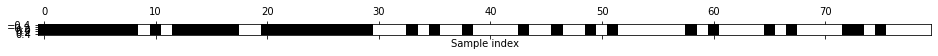

In [16]:
# use f_classif (the default) and SelectPercentile to select 50% of features:
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set:
X_train_selected = select.transform(X_train)

mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index");

Impact on performance: check how the transformation affects the performance of our learning algorithms.

In [17]:
from sklearn.linear_model import LogisticRegression

# transform test data:
X_test_selected = select.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print("LogisticRegression score with all features: {:.3f}".format(lr.score(X_test, y_test)))
lr.fit(X_train_selected, y_train)
print("LogisticRegression score with only selected features: {:.3f}".format(
        lr.score(X_test_selected, y_test)))

LogisticRegression score with all features: 0.919
LogisticRegression score with only selected features: 0.912


### Model-based Feature Selection
Model-based feature selection uses a supervised machine learning model to judge the importance of each feature, and keeps only the most important ones. They consider all features together, and are thus able to capture interactions: a feature may be more (or less) informative in combination with others.

The supervised model that is used for feature selection doesn’t need to be the same model that is used for the final supervised modeling, it only needs to be able to measure the (perceived) importance for each feature:

- Decision tree–based models return a `feature_importances_` attribute
- Linear models return coefficients (`coef_`), whose absolute values also reflect feature importance 

In scikit-learn, we can do this using `SelectFromModel`. It requires a model and a threshold. Threshold='median' means that the median observed feature importance will be the threshold, which will remove 50% of the features.
```
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")
```

* Random Forests are known to produce good estimates of feature importance
    * Based on how often a feature is used high up in the trees
    * Based on Information Gain or Mean Decrease in Impurity (MDI)
    * Use with care: [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)
    * Tune the RandomForest (e.g. `min_samples_leaf`)
    * Use permutation importance (coming up)
* In our example, all but two of the original features were selected, and most of the noise features removed.
* Our logistic regression model improves further

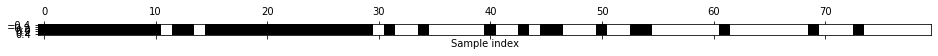

In [18]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index");

In [19]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("LogisticRegression test score: {:.3f}".format(score))

LogisticRegression test score: 0.940


### Iterative feature selection

Instead of building a model to remove many features at once, we can also just ask it to remove the worst feature, then retrain, remove another feature, etc. This is known as _recursive feature elimination_ (RFE).
```
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)
```

Vice versa, we could also ask it to iteratively add one feature at a time. This is called _forward selection_.

In both cases, we need to define beforehand how many features to select. When this is unknown, one often considers this as an additional hyperparameter of the whole process (pipeline) that needs to be optimized.

Can be rather slow.

RFE result:
* Fewer noise features, only 1 original feature removed
* LogisticRegression performance about the same

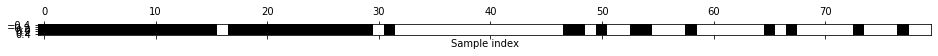

In [20]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)

select.fit(X_train, y_train)
# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index");

In [21]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("LogisticRegression Test score: {:.3f}".format(score))

LogisticRegression Test score: 0.930


### Permutation feature importance

* Model inspection technique, especially useful for non-linear or opaque estimators. 
* Defined as **the decrease in a model score when a single feature value is randomly shuffled**.
* This breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. 
* Model agnostic, metric agnostic, and can be calculated many times with different permutations.
* The problem with impurity based techniques (e.g. Random Forest)
    * Gives importance to features not predictive on unseen data. 
        * Permutation feature importance can be applied to unseen data.
    * Strong bias towards high cardinality features (e.g. numerical features).
        * Permutation feature importances do not exhibit such a bias. 

##### Example (Titanic dataset)
* We add a random feature as well: Random Forest deems it important!
* Low cardinality feature `sex` and `pclass` are actually more important
* Note: this requires the development version of sklearn

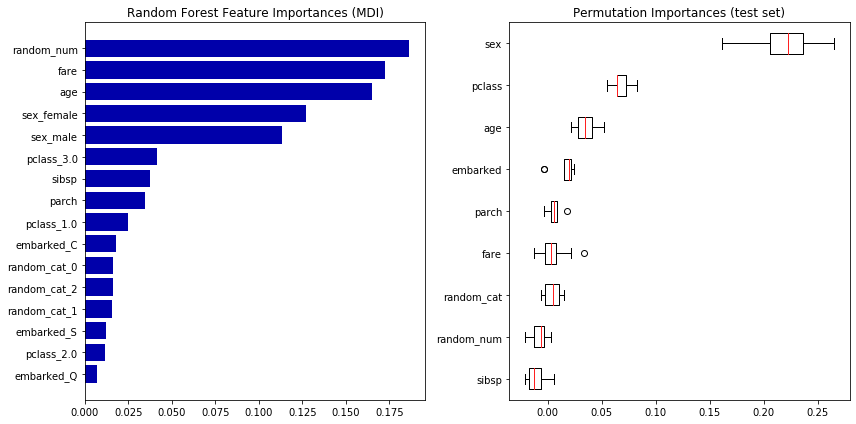

In [39]:
# Example from https://scikit-learn.org/dev/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf.fit(X_train, y_train)

#RF based importances
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
y_ticks = np.arange(0, len(feature_names))
ax[0].barh(y_ticks, tree_feature_importances[sorted_idx])
ax[0].set_yticklabels(feature_names[sorted_idx])
ax[0].set_yticks(y_ticks)
ax[0].set_title("Random Forest Feature Importances (MDI)")

result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

ax[1].boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax[1].set_title("Permutation Importances (test set)")

fig.tight_layout()
plt.show()

We can also compute the permutation importances on the training set. 
* `random_num` gets a significantly higher importance ranking than when computed on the test set.
* This shows that the RF model has enough capacity to use that random numerical feature to overfit.

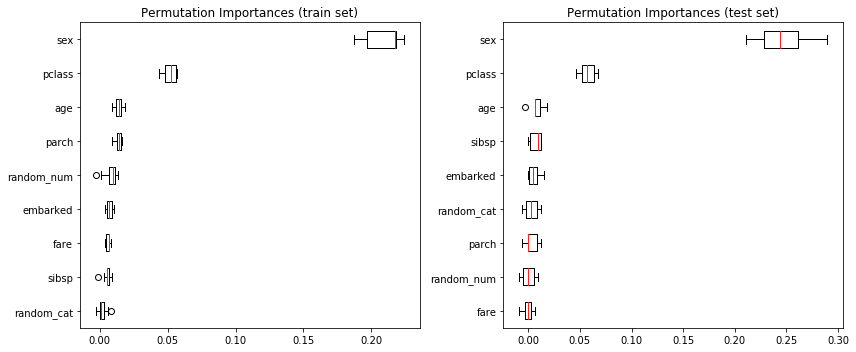

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

ax[1].boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax[1].set_title("Permutation Importances (test set)")


result = permutation_importance(rf, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

ax[0].boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax[0].set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

Let's rerun this with a more regularized Random Forest (`min_samples_leaf=10`):

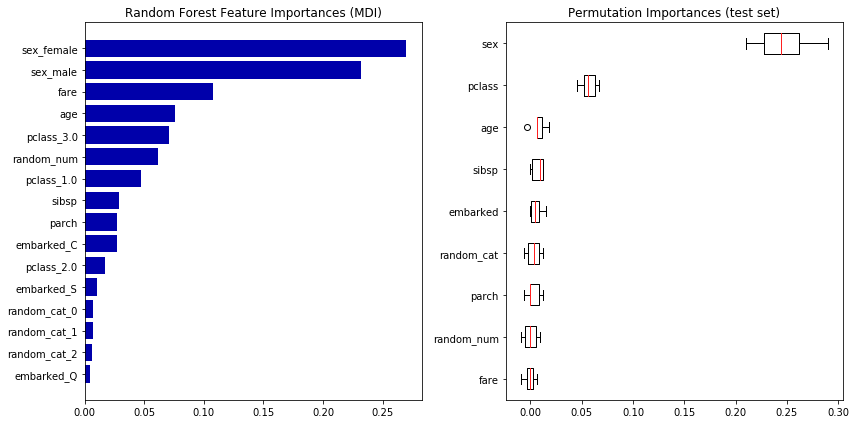

In [44]:
rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42, min_samples_leaf=10))
])
rf.fit(X_train, y_train)

#RF based importances
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
y_ticks = np.arange(0, len(feature_names))
ax[0].barh(y_ticks, tree_feature_importances[sorted_idx])
ax[0].set_yticklabels(feature_names[sorted_idx])
ax[0].set_yticks(y_ticks)
ax[0].set_title("Random Forest Feature Importances (MDI)")

result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

ax[1].boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax[1].set_title("Permutation Importances (test set)")

fig.tight_layout()
plt.show()

### Feature selection wrap-up

Automatic feature selection can be helpful when:

- You expect some inputs to be uninformative
- Your model does not select features internally (as tree-based models do)
    - Even then it may help
- You need to speed up prediction without loosing much accuracy
- You want a more interpretable model (with fewer variables)

## Scaling

When the features have different scales (their values range between very different minimum and maximum values), it makes sense to scale them to the same range. Otherwise, one feature will overpower the others, expecially when raised to the $n$th power.

- We can rescale features between 0 and 1 using `MinMaxScaler`. 
- Remember to `fit_transform` the training data, then `transform` the test data

In [23]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, 
                                                    random_state=0)

# rescale data:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Several scaling techniques are available:
- `StandardScaler` rescales all features to mean=0 and variance=1
    - Does not ensure and min/max value
- `RobustScaler` uses the median and quartiles
    - Median m: half of the values < m, half > m
    - Lower Quartile lq: 1/4 of values < lq
    - Upper Quartile uq: 1/4 of values > uq
    - Ignores _outliers_, brings all features to same scale
- `MinMaxScaler` brings all feature values between 0 and 1
- `Normalizer` scales data such that the feature vector has Euclidean length 1
    - Projects data to the unit circle
    - Used when only the direction/angle of the data matters

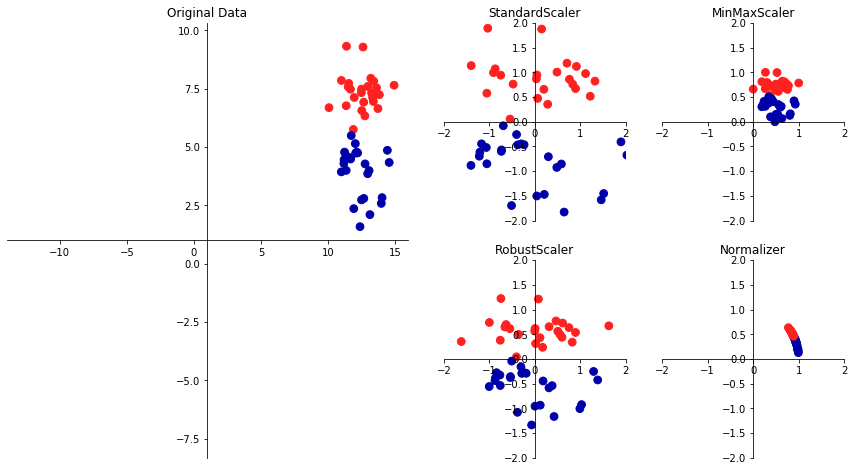

In [24]:
mglearn.plots.plot_scaling()

### Applying scaling transformations
- Lets apply a scaling transformation _manually_, then use it to train a learning algorithm
- First, split the data in training and test set
- Next, we `fit` the preprocessor on the __training data__
    - This computes the necessary transformation parameters
    - For `MinMaxScaler`, these are the min/max values for every feature
- After fitting, we can `transform` the training and test data 

In [25]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    random_state=1)

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train);

``` python
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
```

In [27]:
# transform training data
X_train_scaled = scaler.transform(X_train)
print("Training data per-feature minimum after scaling:\n {}".format(
        X_train_scaled.min(axis=0)))
print("Training data per-feature maximum after scaling:\n {}".format(
        X_train_scaled.max(axis=0)))

Training data per-feature minimum after scaling:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Training data per-feature maximum after scaling:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


* After scaling the test data, the values are not exactly between 0 and 1
* This is correct: we used the min/max values from the training data only
* We are still interested in how well our preprocessing+learning model generalizes from the training to the test data

``` python
X_test_scaled = scaler.transform(X_test)
```

In [28]:
# transform test data
X_test_scaled = scaler.transform(X_test)
# print test data properties after scaling
print("Test data per-feature minimum after scaling:\n{}".format(X_test_scaled.min(axis=0)))
print("Test data per-feature maximum after scaling:\n{}".format(X_test_scaled.max(axis=0)))

Test data per-feature minimum after scaling:
[ 0.034  0.023  0.031  0.011  0.141  0.044  0.     0.     0.154 -0.006
 -0.001  0.006  0.004  0.001  0.039  0.011  0.     0.    -0.032  0.007
  0.027  0.058  0.02   0.009  0.109  0.026  0.     0.    -0.    -0.002]
Test data per-feature maximum after scaling:
[0.958 0.815 0.956 0.894 0.811 1.22  0.88  0.933 0.932 1.037 0.427 0.498
 0.441 0.284 0.487 0.739 0.767 0.629 1.337 0.391 0.896 0.793 0.849 0.745
 0.915 1.132 1.07  0.924 1.205 1.631]


- Remember to `fit` and `transform` on the training data, then `transform` the test data

* 2nd figure: `fit` on training set, `transform` on training and test set
* 3rd figure: `fit` and `transform` on the training data
    * Test data points nowhere near same training data points
    * Trained model will have a hard time generalizing correctly

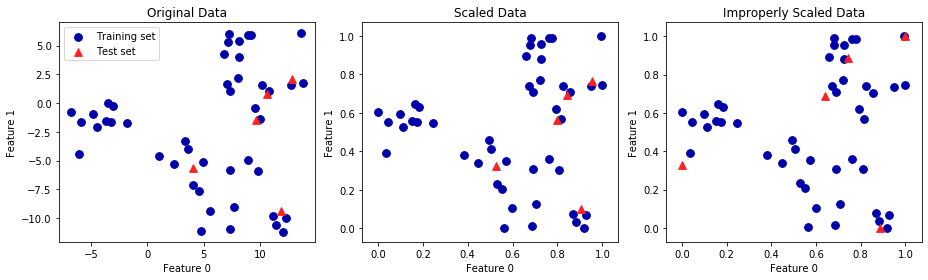

In [46]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

from sklearn.datasets import make_blobs
# make synthetic data
X, _ = make_blobs(n_samples=50, centers=5, random_state=4, cluster_std=2)
# split it into training and test set
X_train, X_test = train_test_split(X, random_state=5, test_size=.1)

# plot the training and test set
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
axes[0].scatter(X_train[:, 0], X_train[:, 1],
                c=mglearn.cm2(0), label="Training set", s=60)
axes[0].scatter(X_test[:, 0], X_test[:, 1], marker='^',
                c=mglearn.cm2(1), label="Test set", s=60)
axes[0].legend(loc='upper left')
axes[0].set_title("Original Data")

# scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# visualize the properly scaled data
axes[1].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1],
                c=mglearn.cm2(0), label="Training set", s=60)
axes[1].scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], marker='^',
                c=mglearn.cm2(1), label="Test set", s=60)
axes[1].set_title("Scaled Data")

# rescale the test set separately
# so that test set min is 0 and test set max is 1
# DO NOT DO THIS! For illustration purposes only
test_scaler = MinMaxScaler()
test_scaler.fit(X_test)
X_test_scaled_badly = test_scaler.transform(X_test)

# visualize wrongly scaled data
axes[2].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1],
                c=mglearn.cm2(0), label="training set", s=60)
axes[2].scatter(X_test_scaled_badly[:, 0], X_test_scaled_badly[:, 1],
                marker='^', c=mglearn.cm2(1), label="test set", s=60)
axes[2].set_title("Improperly Scaled Data")

for ax in axes:
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
fig.tight_layout()

* Note: you can fit and transform the training together with `fit_transform`
* To transform the test data, you always need to `fit` on the training data and `transform` the test data

``` python
scaler = StandardScaler()
# calling fit and transform in sequence (using method chaining)
X_scaled = scaler.fit(X).transform(X)
# same result, but more efficient computation
X_scaled_d = scaler.fit_transform(X)
```

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# calling fit and transform in sequence (using method chaining)
X_scaled = scaler.fit(X).transform(X)
# same result, but more efficient computation
X_scaled_d = scaler.fit_transform(X)

### How great is the effect of scaling?
* First, we train the (linear) SVM without scaling

In [31]:
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    random_state=0)

svm = LinearSVC()
svm.fit(X_train, y_train)
print("LinearSVC test set accuracy: {:.2f}".format(svm.score(X_test, y_test)))

LinearSVC test set accuracy: 0.93


* With scaling, we get a much better model

In [32]:
# preprocessing using 0-1 scaling
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# learning an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scoring on the scaled test set
print("LinearSVM (with scaling) test set accuracy: {:.2f}".format(svm.score(X_test_scaled, y_test)))

LinearSVM (with scaling) test set accuracy: 0.97


### Scaling for polynomial regression
After scaling, we extract polynomial features and interactions up to a degree of 2. Note how we `fit` the `PolynomialFeatures` only on the training data and then apply it (`transform`) on both the training and test data.

`PolynomialFeatures` will add a new features for each possible interaction (product) of up to 2 input features, including the products of a feature with itself (the squares). Hence, $\frac{13!}{11!  2!}$ + 13 + 13 features total.


In [33]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

# rescale data:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
poly = PolynomialFeatures(degree=2).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_poly.shape: {}".format(X_train_poly.shape))

X_train.shape: (379, 13)
X_train_poly.shape: (379, 105)


The exact correspondence between input and output features can be found using the get_feature_names method:

In [35]:
print("Polynomial feature names:\n{}".format(poly.get_feature_names()))

Polynomial feature names:
['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x6 x12', 'x7^2', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x7 x12', 'x8^2', 'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x9^2', 'x9 x10', 'x9 x11', 'x9 x12', 'x10^2', 'x10 x11', 'x10 x12', 'x11^2', 'x11 x12', 'x12^2']


Let’s compare the performance of a linear model (Ridge regression) on the data with and without interactions:

In [36]:
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_train_scaled, y_train)
print("Score without interactions: {:.3f}".format(
        ridge.score(X_test_scaled, y_test)))
ridge = Ridge().fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(
        ridge.score(X_test_poly, y_test)))

Score without interactions: 0.621
Score with interactions: 0.753


Clearly, the interactions and polynomial features gave us a good boost in performance when using Ridge. When using a more complex model like a random forest, the story is a bit different, though:

In [37]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100).fit(X_train_scaled, y_train)
print("Score without interactions: {:.3f}".format(
        rf.score(X_test_scaled, y_test)))
rf = RandomForestRegressor(n_estimators=100).fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(rf.score(X_test_poly, y_test)))

Score without interactions: 0.808
Score with interactions: 0.771


The random forest does not benefit from the interaction features, in fact, performance decreases...

Adding polynomials is typically good for linear models, but not a cure-for-all. Always evaluate the performance of models when adding preprocessing steps.

* What if we want the cross-validated evaluation?
    - Apply scaling on every fold independently?

### Missing value imputation
* Many sci-kit learn algorithms cannot handle missing value
* `Imputer` replaces specific values
    * `missing_values` (default 'NaN') placeholder for the missing value
    * `strategy`:
        - `mean`, replace using the mean along the axis
        - `median`, replace using the median along the axis
        - `most_frequent`, replace using the most frequent value
* Many more advanced techniques exist, but not yet in scikit-learn
    * e.g. low rank approximations (uses matrix factorization)

``` python
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit_transform(X1_train)
```

In [55]:
from sklearn.impute import SimpleImputer
X1_train = [[1, 2], [np.nan, 3], [7, np.nan]];
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X1 = [[np.nan, 2], [6, np.nan], [7, 6]]
print("Missing data:\n {}".format(np.array(X1_train) ))                          
print("Imputed data:\n {}".format(imp.fit_transform(X1_train))  ) 

Missing data:
 [[ 1.  2.]
 [nan  3.]
 [ 7. nan]]
Imputed data:
 [[1.  2. ]
 [4.  3. ]
 [7.  2.5]]


## Building Pipelines
* In scikit-learn, a `pipeline` combines multiple processing _steps_ in a single estimator
* All but the last step should be transformer (have a `transform` method)
    * The last step can be a transformer too (e.g. Scaler+PCA)
* It has a `fit`, `predict`, and `score` method, just like any other learning algorithm
* Pipelines are built as a list of steps, which are (name, algorithm) tuples
    * The name can be anything you want, but can't contain `'__'`
    * We use `'__'` to refer to the hyperparameters, e.g. `svm__C`
* Let's build, train, and score a `MinMaxScaler` + `LinearSVC` pipeline:

``` python
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", LinearSVC())])
pipe.fit(X_train, y_train).score(X_test, y_test)
```

In [56]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", LinearSVC())])

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    random_state=1)
pipe.fit(X_train, y_train)
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


* Now with cross-validation:
``` python
scores = cross_val_score(pipe, cancer.data, cancer.target)
```

In [57]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe, cancer.data, cancer.target)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [0.982 0.974 0.965 0.965 0.991]
Average cross-validation score: 0.98


* We can retrieve the trained SVM by querying the right step indices
``` python
pipe.steps[1][1]
```

In [58]:
pipe.fit(X_train, y_train)
print("SVM component: {}".format(pipe.steps[1][1]))

SVM component: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


* Or we can use the `named_steps` dictionary
``` python
pipe.named_steps['svm']
```

In [59]:
print("SVM component: {}".format(pipe.named_steps['svm']))

SVM component: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


* When you don't need specific names for specific steps, you can use `make_pipeline`
    * Assigns names to steps automatically
``` python
pipe_short = make_pipeline(MinMaxScaler(), LinearSVC(C=100))
print("Pipeline steps:\n{}".format(pipe_short.steps))
```

In [60]:
from sklearn.pipeline import make_pipeline
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), LinearSVC(C=100))
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('linearsvc', LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0))]


Visualization of a pipeline `fit` and `predict`

<img src="../images/07_pipelines.png" alt="ml" style="width: 700px;"/>

## Hyperparameter Selection with Preprocessing 
* If we also want to optimize our hyperparameters, things get more complicated
* Indeed, when we `fit` the preprocessor (`MinMaxScaler`), we used _all_ the training data.
* The cross-validation splits in GridSearchCV will have training sets preprocessed with information from the test sets (data leakage)

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    random_state=0)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# illustration purposes only, don't use this code
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("Best parameters: ", grid.best_params_)

Best cross-validation accuracy: 0.98
Best set score: 0.97
Best parameters:  {'C': 1, 'gamma': 1}


Visualization of what happens in this code
* During cross-validation (grid search) we evaluate hyperparameter settings on a validation set that was preprocessed with information in that validation set
* This will lead to overly optimistic results during cross-validation
* When we want to use the optimized hyperparameters on the held-out test data, the selected hyperparameters may be suboptimal.
* To solve this, we need to _glue_ the preprocessing and learning algorithms together by building a pipeline

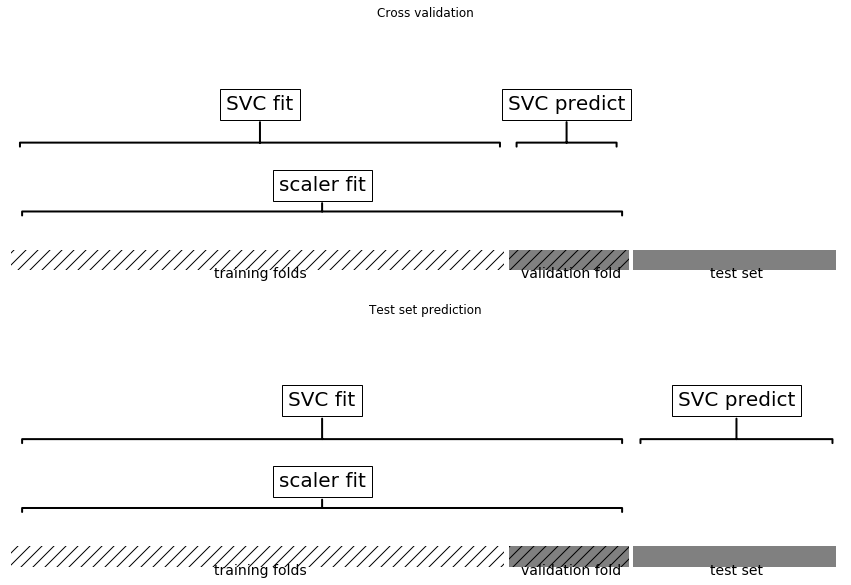

In [63]:
mglearn.plots.plot_improper_processing()

### Using Pipelines in Grid-searches
* We can use the pipeline as a single estimator in `cross_val_score` or `GridSearchCV`
* To define a grid, refer to the hyperparameters of the steps
    * Step `svm`, parameter `C` becomes `svm__C`
    
``` python
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = pipeline.Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
```

In [64]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [65]:
from sklearn import pipeline

pipe = pipeline.Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


* Now, the preprocessors are refit with only the training data in each cross-validation split.

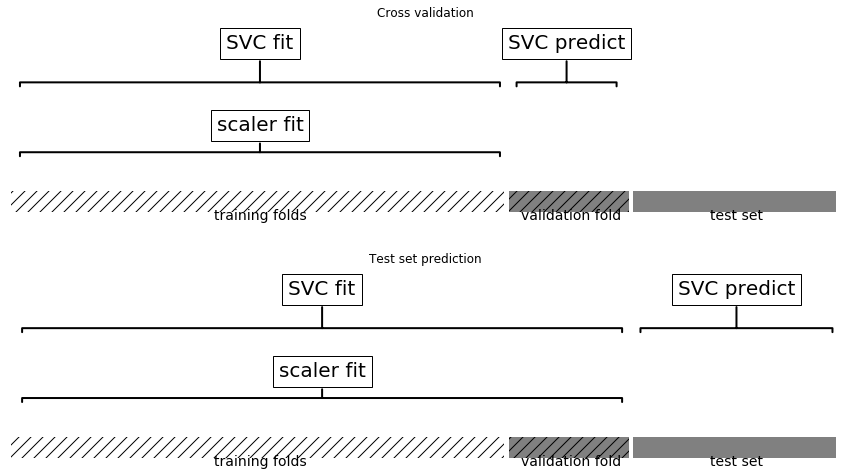

In [66]:
mglearn.plots.plot_proper_processing()

* When we request the best estimator of the grid search, we'll get the best pipeline
``` python
grid.best_estimator_
```

In [67]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svm',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=1, kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)


* And we can drill down to individual components and their properties
``` python
grid.best_estimator_.named_steps["svm"]
```

In [68]:
# Get the SVM
print("SVM step:\n{}".format(
      grid.best_estimator_.named_steps["svm"]))

SVM step:
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [69]:
# Get the SVM dual coefficients (support vector weights)
print("SVM support vector coefficients:\n{}".format(
      grid.best_estimator_.named_steps["svm"].dual_coef_))

SVM support vector coefficients:
[[-1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -0.822 -0.609
  -0.93  -1.    -0.665 -1.    -0.793 -1.    -1.    -1.    -1.    -1.
  -1.    -0.63  -1.    -1.    -1.    -0.166 -0.575 -1.    -0.119 -1.
  -0.38  -1.    -0.55  -0.048 -0.606 -1.    -0.071 -1.    -0.126 -0.106
  -0.285 -1.    -1.    -1.    -0.46   1.     0.932  1.     1.     0.901
   1.     0.911  1.     1.     1.     0.653  1.     1.     0.953  0.577
   1.     1.     1.     1.     1.     0.659  1.     1.     0.757  1.
   1.     1.     1.     1.     1.     1.     0.096  0.274  0.329  1.
   1.     1.     0.491  1.     0.41 ]]


### Grid-searching preprocessing steps and model parameters
* We can use grid search to optimize the hyperparameters of our preprocessing steps and learning algorithms at the same time
* Consider the following pipeline:
    - `StandardScaler`, without hyperparameters
    - `PolynomialFeatures`, with the max. _degree_ of polynomials
    - `Ridge` regression, with L2 regularization parameter _alpha_
    
``` python
pipe = pipeline.make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())
```

In [75]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)
from sklearn.preprocessing import PolynomialFeatures
pipe = pipeline.make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

* We don't know the optimal polynomial degree or alpha value, so we use a grid search (or random search) to find the optimal values
``` python
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=1)
grid.fit(X_train, y_train)
```

In [76]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
# Note: I had to use n_jobs=1. (n_jobs=-1 stalls on my machine)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=1)
grid.fit(X_train, y_train);

* Visualing the $R^2$ results as a heatmap:

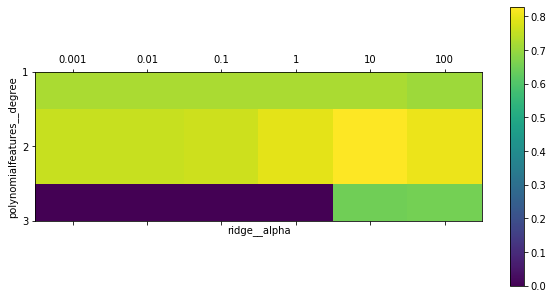

In [77]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
            vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
           param_grid['polynomialfeatures__degree'])

plt.colorbar();

* Here, degree-2 polynomials help (but degree-3 ones don't), and tuning the alpha parameter helps as well.
* Not using the polynomial features leads to suboptimal results (see the results for degree 1)

In [78]:
print("Best parameters: {}".format(grid.best_params_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}
Test-set score: 0.77


## Approaching machine learning problems

* Running your favourite algorithm on every problem is usually not a great way to start
* Consider the problem at large
    - Do you want exploratory analysis or (black box) modelling?
    - How to define and measure success? Are there costs involved?
    - Do you have the right data? How can you make it better?
* Build prototypes early-on to evaluate the above.
* Analyse your model's mistakes
    - Should you collect more, or additional data?
    - Should the task be reformulated?
    - Often a higher payoff than endless grid searching
* Technical debt
    - Very complex machine learning prototypes are hard/impossible to put into practice
    - There is a creation-maintenance trade-off
    - See 'Machine Learning: The High Interest Credit Card of Technical Debt'

### Real world evaluations
* Accuracy is seldomly the right measure. Usually, costs are involved.
* Don't just evaluate your predictions themselves, also evaluate how the outcome improves _after_ you take actions based on them
* Beware of non-representative samples. You often don't have the data you really need.
* Adversarial situations (e.g. spam filtering) can subvert your predictions
* Data leakage: the signal your model found was just an artifact of your data
    - See 'Why Should I Trust You?' by Marco Ribeiro et al.
* A/B testing to evaluate algorithms in the wild
    - More advanced: bandit algorithms

## Summary

* Transforming the features can drastically impact performance
    - Constructing new features makes linear models more powerful
    - Selecting features can reduce overfitting and improve performance
    - Scaling is important for many distance-based methods (e.g. kNN, SVM)
* Pipelines allow us to encapsulate multiple steps into a single estimator
    - Has `fit`, `transform`, and `predict` methods
* Avoids data leakage, hence crucial for proper evaluation
* Choosing the right combination of feature extraction, preprocessing, and models is somewhat of an art.
* Pipelines + Grid/Random Search help, but search space is huge
    - Smarter techniques are being researched (see later)
* Real world applications require careful thought, prototyping, and tireless evaluation.   